## CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


### Implementation

Below is a Keras implementation of a basic Convolutional Neural Network using:
1. Dropout Regularization
2. BatchNormalization
3. ReduceLROnPlateau Callback
4. Adam optimizer with Nesterov momentum

In [1]:
!nvidia-smi

Fri Jun  2 13:21:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Libraries

In [73]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
%matplotlib inline

import tensorflow as tf
import keras
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPool2D,BatchNormalization,Dropout,Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

## Data Processing

In [74]:
# Load CIFAR-10 dataset
(X_train,y_train),(X_val,y_val) = cifar10.load_data()

In [75]:
print('X_train shape:',X_train.shape)
print('X_val shape:',X_val.shape)
print('y_train shape:',y_train.shape)
print('y_val shape:',y_val.shape)

X_train shape: (50000, 32, 32, 3)
X_val shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_val shape: (10000, 1)


In [76]:
# Normalize pixel data
X_train = X_train/255.0
X_val = X_val/255.0

# One Hot Encoding target labels
y_cat_train = to_categorical(y_train,10)
y_cat_val = to_categorical(y_val,10)

## Model Creation

In [77]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

In [114]:
# Create Keras CNN model using Dropout and BatchNorm Regularizations
model = Sequential()

model.add(DefaultConv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(DefaultConv2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(DefaultConv2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(DefaultConv2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(DefaultConv2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(DefaultConv2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [115]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 32, 32, 32)        864       
_________________________________________________________________
batch_normalization_57 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_24 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 32, 32, 64)        18432     
_________________________________________________________________
batch_normalization_58 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_25 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 16, 16, 64)      

## Model Training

In [116]:
# Apply Nadam optimizer and categorical crossentropy loss
optimizer = tf.keras.optimizers.Nadam()
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [117]:
# Defining callbacks for model training
EPOCHS = 25
BATCH_SIZE=32
checkpoint_filepath = '/kaggle/working/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=2,min_lr=0.00001,mode='auto')

In [118]:
history = model.fit(x=X_train,y=y_cat_train,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[learning_rate_reduction,model_checkpoint_callback],validation_split=0.2)

Epoch 1/25
1250/1250 [==============================] - 14s 9ms/step - loss: 1.6446 - accuracy: 0.4018 - val_loss: 1.2187 - val_accuracy: 0.5671
Epoch 2/25
1250/1250 [==============================] - 11s 9ms/step - loss: 1.2144 - accuracy: 0.5687 - val_loss: 1.0657 - val_accuracy: 0.6238
Epoch 3/25
1250/1250 [==============================] - 11s 9ms/step - loss: 1.0315 - accuracy: 0.6402 - val_loss: 0.9282 - val_accuracy: 0.6662
Epoch 4/25
1250/1250 [==============================] - 10s 8ms/step - loss: 0.9127 - accuracy: 0.6841 - val_loss: 0.7745 - val_accuracy: 0.7303
Epoch 5/25
1250/1250 [==============================] - 11s 9ms/step - loss: 0.8245 - accuracy: 0.7206 - val_loss: 1.0330 - val_accuracy: 0.6509
Epoch 6/25
1250/1250 [==============================] - 11s 9ms/step - loss: 0.7549 - accuracy: 0.7437 - val_loss: 0.6912 - val_accuracy: 0.7642
Epoch 7/25
1250/1250 [==============================] - 11s 9ms/step - loss: 0.6912 - accuracy: 0.7650 - val_loss: 0.7287 - val_ac

## Model Test Accuracy

In [119]:
evaluation = model.evaluate(X_val, y_cat_val)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

313/313 [==============================] - 1s 4ms/step - loss: 0.4501 - accuracy: 0.8671
Test Accuracy : 86.71%


## Plot metrics 

In [120]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
     
    fig, ax = plt.subplots(figsize=(15, 4))
 
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
         
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
     
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0,EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

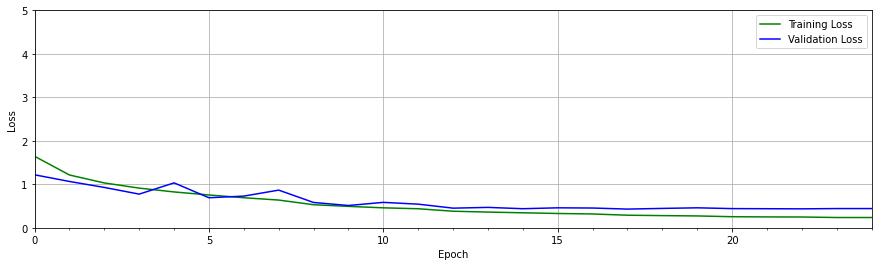

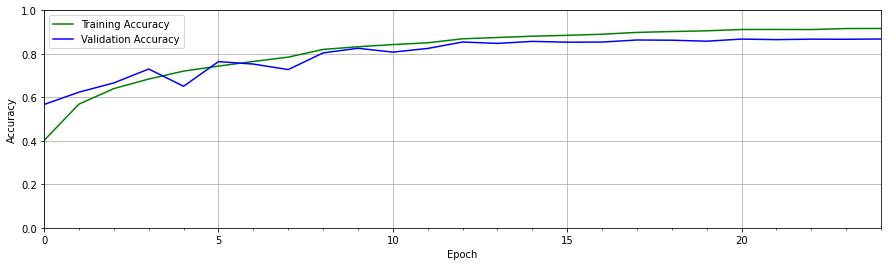

In [121]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]
     
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

## References

1.  https://keras.io/examples/vision/mnist_convnet/  

2.  https://learnopencv.com/implementing-cnn-tensorflow-keras/#:~:text=In%20this%20section%2C%20we%20will%20define%20a%20simple,model.compile%20%28%29%20Train%20the%20model%20with%20model.fit%20%28%29  

3.  https://github.com/SupreethRao99/Kaggle/blob/master/Waste_Classification_Data.ipynb